test for 2D simulation

Ornstein-Uhlenbeck process:
Xn - Xn-1 = theta*(mu-y)* dt + sigma* noise

drift term = theta*(mu-y)

diffusion term = sigma * noise

2D simulation:
Xn - Xn-1 = D(Xn-1, Yn-1)F(Xn-1, Yn-1)dt - (2Ddt)^1/2 N(0,1)

drift term = D(r)F(r)* dt

diffusion term = np.sqrt(2Ddt)* noise


# 1D simulation

In [23]:
import math
import numpy as np                  # numpy
import pandas as pd
import seaborn as sns               # for probability distribution

import matplotlib.pyplot as plt     # pyplot
from matplotlib import cm           # colormap
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm, LogNorm


plt.rcParams["figure.figsize"] = (20,10) #make graph larger

In [29]:
#para well
def DiffCoef_Para(x):
    D = D_out * np.ones(np.shape(x))
    D[a>np.absolute(x)] = (D_out - D_in) * (x[a>np.absolute(x)]**2)/(a**2) + D_in
    return D

# Apply periodic boundary condition
# Restrict to [-L, L)
def PeriodicBC(x, L): 
    return (x+L)%(2.0 * L) - L

def Potential_Para(x):
    V = V_out * np.ones(np.shape(x))
    V[a>np.absolute(x)] = (V_out-V_in)*(x[a>np.absolute(x)]**2)/(a**2) + V_in
    return V

#need some modifications in higher dimensions simulations
#since force is vector in higher dimensions (for 3D, it should be a 3*3*3 array instead of a list)
def Force_Para(x): 
    f = np.zeros(np.shape(x))
    f[a>np.absolute(x)] = -(V_out - V_in) * (2*x[a>np.absolute(x)])/(a**2)
    return f

# cell properties
def bound(x2):      # assume the particle would bounce one times only
    x = x2 - (np.sign(x2) * L)
    x2 = np.sign(x2) * L - x
    return x2
def real_bound(x2): # particle will move from one side to another side of the cell, treat cell as a continious surface
    x = -np.sign(x2)*L + (x2 - np.sign(x2)*L)
    return x

# MSD
# https://stackoverflow.com/questions/34222272/computing-mean-square-displacement-using-python-and-fft

def msd_straight_forward(r):
    shifts = np.arange(len(r))
    msds = np.zeros(shifts.size)    

    for i, shift in enumerate(shifts):
        diffs = r[:-shift if shift else None] - r[shift:]
        sqdist = np.square(diffs).sum(axis=1)
        msds[i] = sqdist.mean()
    return msds
    
def autocorrFFT(x):
  N=len(x)
  F = np.fft.fft(x, n=2*N)  #2*N because of zero-padding
  PSD = F * F.conjugate()
  res = np.fft.ifft(PSD)
  res= (res[:N]).real   #now we have the autocorrelation in convention B
  n=N*np.ones(N)-np.arange(0,N) #divide res(m) by (N-m)
  return res/n #this is the autocorrelation in convention A

def msd_fft(r):
  N=len(r)
  D=np.square(r).sum(axis=1) 
  D=np.append(D,0) 
  S2=sum([autocorrFFT(r[:, i]) for i in range(r.shape[1])])
  Q=2*D.sum()
  S1=np.zeros(N)
  for m in range(N):
      Q=Q-D[m-1]-D[N-m]
      S1[m]=Q/(N-m)
  return S1-2*S2
  

In [46]:
D_out = 1           # diffusivity outside the well
D_in = 1        # diffusivity inside the well, impossible to have 0 diffusivity
V_out = 0           # potential energy outside the well
V_in = -1           # potential energy inside the well, from other paper lab data
a = 2               # well size
L = 5               # "cell" size

t_0 = 0             # start time
t_end = 40          # end time
length = 8000       # number of time division
test_number = 10000   # number of protein

hist_range = 10      # for distribution

well_number = 3     # number of well, still testing

t = np.linspace(t_0, t_end, length)
dt = np.mean (np.diff(t))
x_Para = np.zeros((test_number, length))
y_Para = np.zeros((test_number, length))
D_Para = np.zeros((test_number, length))
V_Para = np.zeros((test_number, length))
P_Para = np.zeros((test_number, length))
x_Para_plot = np.zeros((test_number, length))
y_Para_plot = np.zeros((test_number, length))
# for j in range(test_number,0):
#    x_Para[0,j] = np.random.normal(loc = 0.0, scale = 1.0)
#    y_Para[0,j] = np.random.normal(loc = 0.0, scale = 1.0)
# !!! x_Para_plot and x_Para should be the same


In [47]:
x_noise = np.random.normal(loc = 0.0, scale = 1.0, size = (test_number, length))*np.sqrt(dt)
y_noise = np.random.normal(loc = 0.0, scale = 1.0, size = (test_number, length))*np.sqrt(dt)

In [48]:
# for 1D only
"""
for i in range(0, test_number):
    for j in range (1,length):
        x_Para[i,j] = x_Para[i,j-1] + DiffCoef_Para(x_Para[i,j-1]) * Force_Para(x_Para[i,j-1]) * dt + \
        np.sqrt(2.0 * DiffCoef_Para(x_Para[i,j-1])) * x_noise[i,j]
        y_Para[i,j] = y_Para[i,j-1] + DiffCoef_Para(y_Para[i,j-1]) * Force_Para(y_Para[i,j-1]) * dt + \
        np.sqrt(2.0 * DiffCoef_Para(y_Para[i,j-1])) * y_noise[i,j]

        if np.absolute(x_Para[i,j]) > L:
            x_Para[i,j] = real_bound(x_Para[i, j])
        if np.absolute(y_Para[i,j]) > L:
            y_Para[i,j] = real_bound(y_Para[i, j])

for i in range(0, test_number): #para_plot for plotting the mean plot, not the trajectories plot
    for j in range (1,length):
        x_Para_plot[i,j] = x_Para_plot[i,j-1] + DiffCoef_Para(x_Para_plot[i,j-1]) * Force_Para(x_Para_plot[i,j-1]) * dt + \
        np.sqrt(2.0 * DiffCoef_Para(x_Para_plot[i,j-1])) * x_noise[i,j]
        y_Para_plot[i,j] = y_Para_plot[i,j-1] + DiffCoef_Para(y_Para_plot[i,j-1]) * Force_Para(y_Para_plot[i,j-1]) * dt + \
        np.sqrt(2.0 * DiffCoef_Para(y_Para_plot[i,j-1])) * y_noise[i,j]
"""

# for 2D only
# x_Para_plot is limited within [-L, L)
# x_Para is not limited but only having one well in [-a,a]
"""
for i in range(0, test_number):
    for j in range (1,length):
        r = np.sqrt((x_Para_plot[i, j-1]**2) + (y_Para_plot[i, j-1]**2))
        x_Para_plot[i,j] = x_Para_plot[i,j-1] + DiffCoef_Para(r) * (x_Para_plot[i, j-1]/a * Force_Para(r)) * dt + \
        np.sqrt(2.0 * DiffCoef_Para(r)) * x_noise[i,j]
        y_Para_plot[i,j] = y_Para_plot[i,j-1] + DiffCoef_Para(r) * (y_Para_plot[i, j-1]/a * Force_Para(r)) * dt + \
        np.sqrt(2.0 * DiffCoef_Para(r)) * y_noise[i,j]       
        
        x_Para[i,j] = x_Para[i,j-1] + DiffCoef_Para(r) * (x_Para[i, j-1]/a * Force_Para(r)) * dt + \
            np.sqrt(2.0 * DiffCoef_Para(r)) * x_noise[i,j]
        y_Para[i,j] = y_Para[i,j-1] + DiffCoef_Para(r) * (y_Para[i, j-1]/a * Force_Para(r)) * dt + \
            np.sqrt(2.0 * DiffCoef_Para(r)) * y_noise[i,j]
        
        if np.absolute(x_Para_plot[i,j]) > L:
            x_Para_plot[i,j] = real_bound(x_Para_plot[i, j])
        if np.absolute(y_Para_plot[i,j]) > L:
            y_Para_plot[i,j] = real_bound(y_Para_plot[i, j])
"""
y_tmp = np.random.normal(loc = 0.0, scale = 1.0, size=(3,3))
print(y_tmp)
f = 0 * y_tmp
f[y_tmp>0] = y_tmp[y_tmp>0]**2
print(f)
print(np.zeros(np.shape(f)))

[[-0.24693747  0.91991382  1.51756985]
 [ 0.15744611 -0.49953674 -0.36550623]
 [-2.18486662  1.22206385  0.62213844]]
[[-0.          0.84624143  2.30301824]
 [ 0.02478928 -0.         -0.        ]
 [-0.          1.49344005  0.38705624]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [49]:
x_Para_plot[:, 0] = PeriodicBC(x_Para[:, 0], L)
y_Para_plot[:, 0] = PeriodicBC(y_Para[:, 0], L)
for j in range(1, length):
    r = np.sqrt((x_Para_plot[:, j-1]**2) + (y_Para_plot[:, j-1]**2))
    x_Para[:,j] = x_Para[:,j-1] + DiffCoef_Para(r) * (x_Para_plot[:, j-1]/a * Force_Para(r)) * dt + \
        np.sqrt(2.0 * DiffCoef_Para(r) ) * x_noise[:,j]
    y_Para[:,j] = y_Para[:,j-1] + DiffCoef_Para(r) * (y_Para_plot[:, j-1]/a * Force_Para(r)) * dt + \
        np.sqrt(2.0 * DiffCoef_Para(r) ) * y_noise[:,j]
    x_Para_plot[:, j] = PeriodicBC(x_Para[:, j], L)
    y_Para_plot[:, j] = PeriodicBC(y_Para[:, j], L)

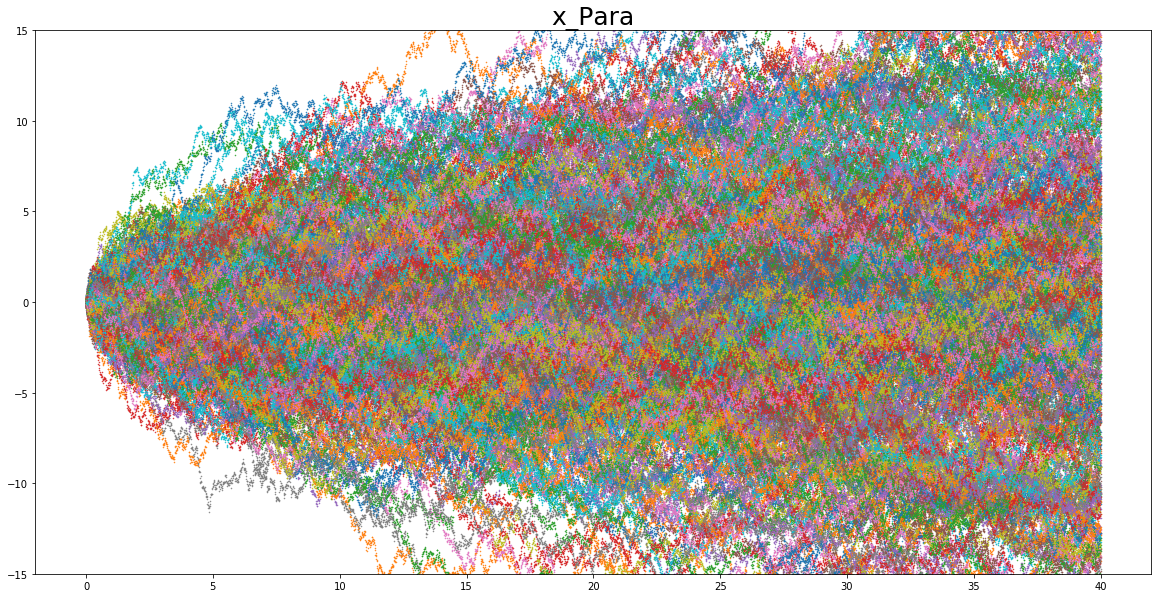

In [7]:
for i in range(test_number):
    plt.title("x_Para", fontsize = 25)
    plt.plot(t,x_Para[i], ".", markersize=1)
    plt.ylim(-15, 15)
# plt.legend(np.arange(test_number), loc = 1, bbox_to_anchor = (1.05, 1))

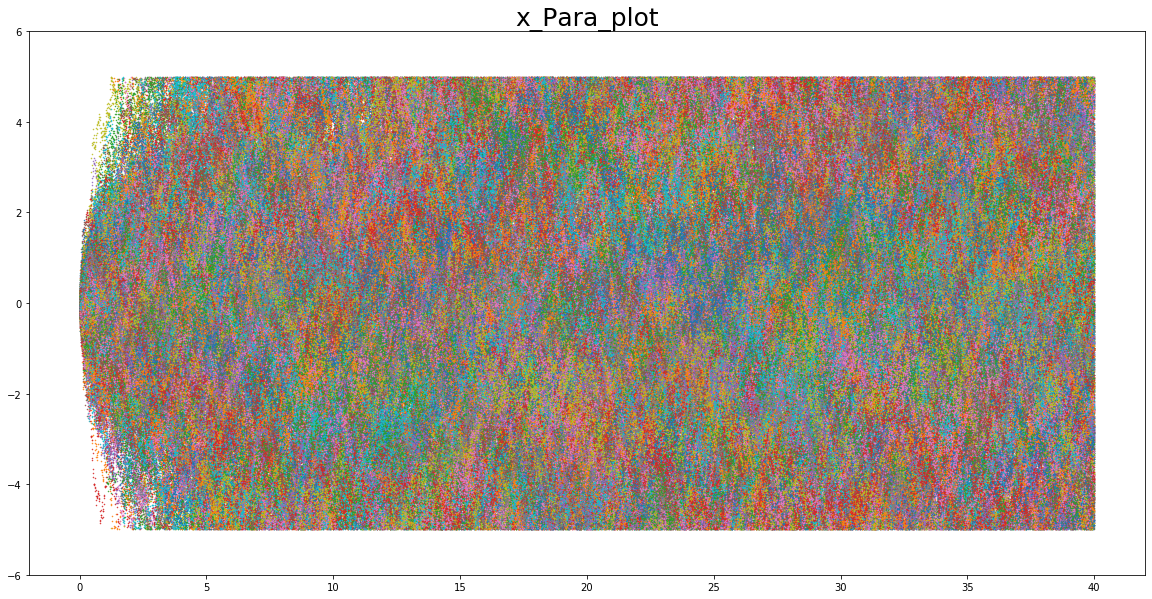

In [8]:
for i in range(test_number):
    plt.title("x_Para_plot", fontsize = 25)
    plt.plot(t,x_Para_plot[i], ".", markersize=1)
    plt.ylim(-6, 6)
# plt.legend(np.arange(test_number), loc = 1, bbox_to_anchor = (1.05, 1))

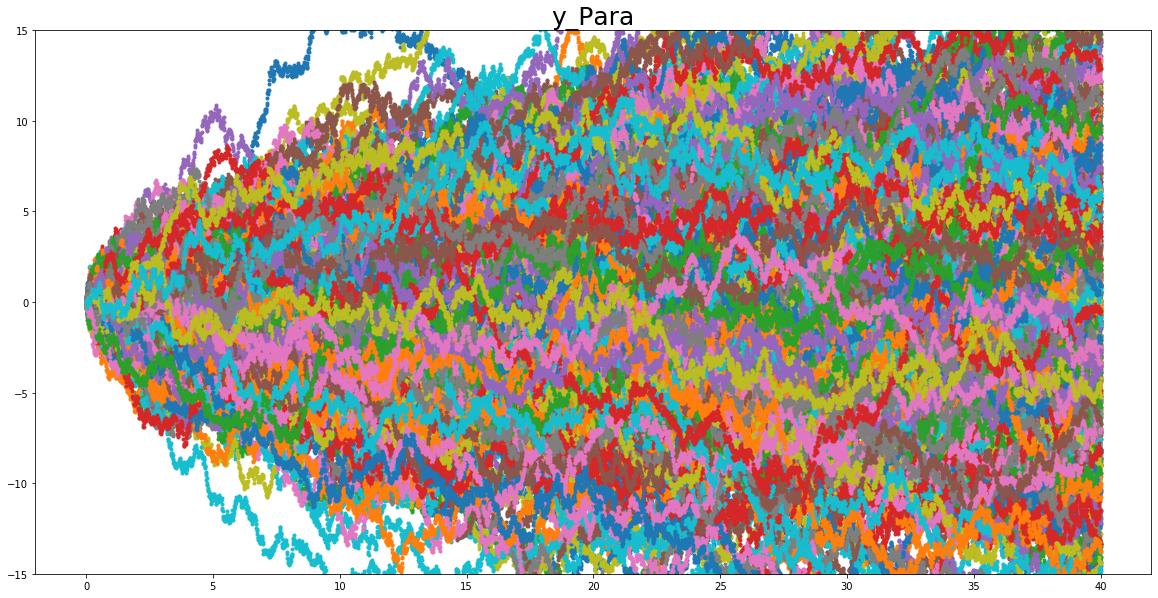

In [9]:
for i in range(test_number):
    plt.title("y_Para", fontsize = 25)
    plt.plot(t,y_Para[i], ".")
    plt.ylim(-15, 15)
# plt.legend(np.arange(test_number), loc = 1, bbox_to_anchor = (1.05, 1))

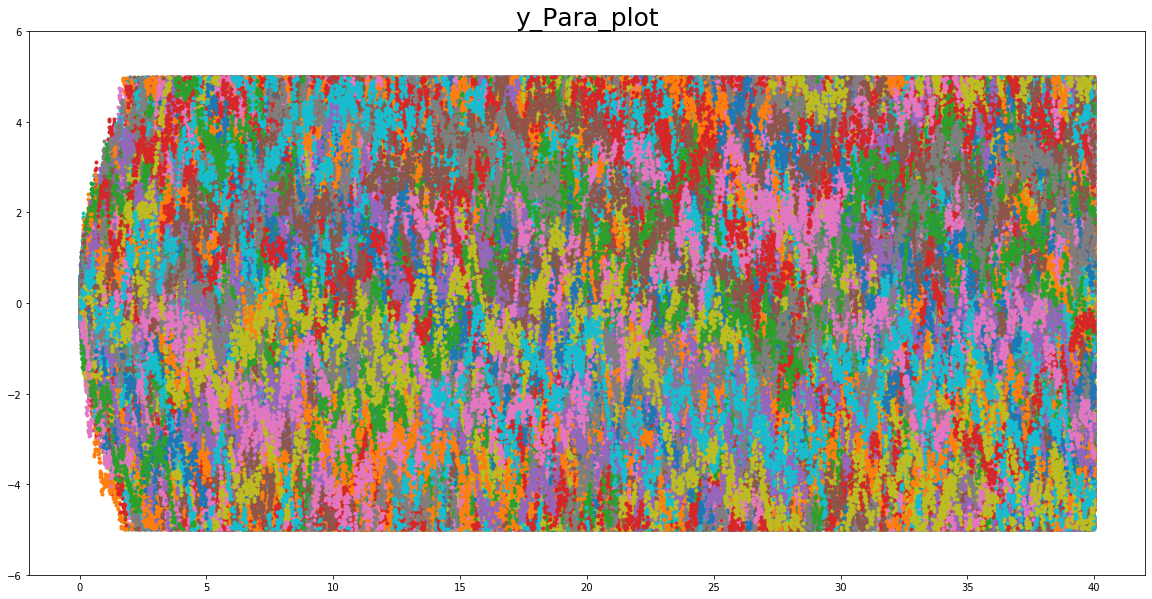

In [10]:
for i in range(test_number):
    plt.title("y_Para_plot", fontsize = 25)
    plt.plot(t,y_Para_plot[i], ".")
    plt.ylim(-6, 6)
# plt.legend(np.arange(test_number), loc = 1, bbox_to_anchor = (1.05, 1))

# 2D simulation

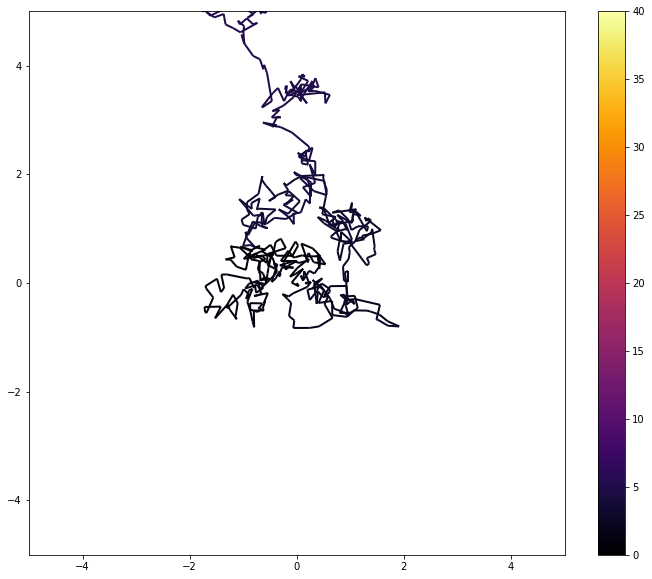

In [11]:
plt.rcParams["figure.figsize"] = (12, 10)

"""
there is error in this plot, the well will become any position that -2<x<2 or -2<y<2, instead of -2<x<2 and -2<y<2, 
it will be cross shape well but not square shape well
"""

points = np.array([x_Para[0], y_Para[0]]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
fig, ax = plt.subplots()
norm = plt.Normalize(t.min(), t.max())
lc = LineCollection(segments, cmap="inferno", norm=norm)
lc.set_array(t)
lc.set_linewidth(2)
line = ax.add_collection(lc)
plt.colorbar(line, ax=ax)

ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
plt.show()

(-5.5, 5.5)

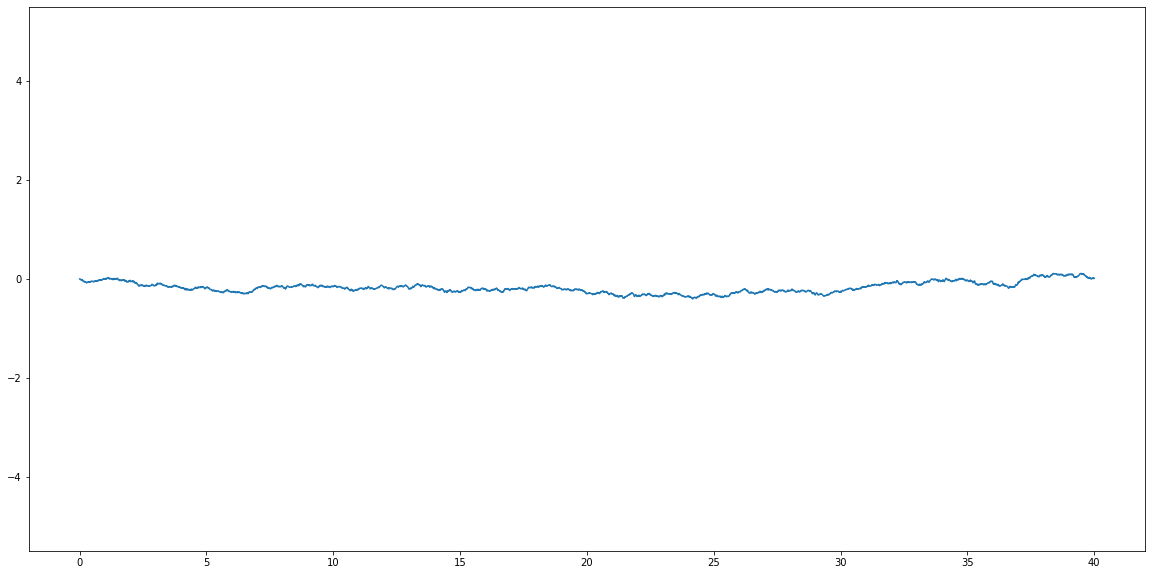

In [12]:
plt.rcParams["figure.figsize"] = (20, 10)

x_Para_mean = np.zeros((1, length))
for i in range(length):
    x_Para_mean[0,i] = x_Para[:, i].mean()

plt.plot(t, x_Para_mean[0,:], label = "para mean")
plt.ylim(-5.5, 5.5)

# Distribution and Prediction

In [13]:
#prediction
predict_length = 1000

x_predict = np.linspace(-5, 5, num = predict_length)
y_predict = np.linspace(-5, 5, num = predict_length)
r_predict = np.zeros(predict_length)
d_predict = np.zeros(predict_length)
v_predict = np.zeros(predict_length)
p1_predict = np.zeros(predict_length)
p2_predict = np.zeros(predict_length)

r_predict = np.sqrt(x_predict**2 + y_predict**2)

for n in range(len(r_predict)):
    if r_predict[n] > 2 or r_predict[n] < -2:
        d_predict[n] = D_out
    else:
        d_predict[n] = (D_out-D_in)*(r_predict[n]**2/a**2) + D_in
for n in range(len(r_predict)):
    if r_predict[n] > 2 or r_predict[n] < -2:
        v_predict[n] = V_out
    else:
        v_predict[n] = (V_out-V_in)*(r_predict[n]**2/a**2) + V_in

for n in range(len(r_predict)):
    p1_predict[n] = math.exp(-v_predict[n])/d_predict[n]


# for normalization
for n in range(len(p1_predict)-1):
    p2_predict[n] = p1_predict[n]/np.sum(p1_predict)

C:\Users\hwSRI\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\hwSRI\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  after removing the cwd from sys.path.
C:\Users\hwSRI\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """
C:\Users\hwSRI\anaconda3\l

Text(0.5, 0.98, 'x_Para_plot')

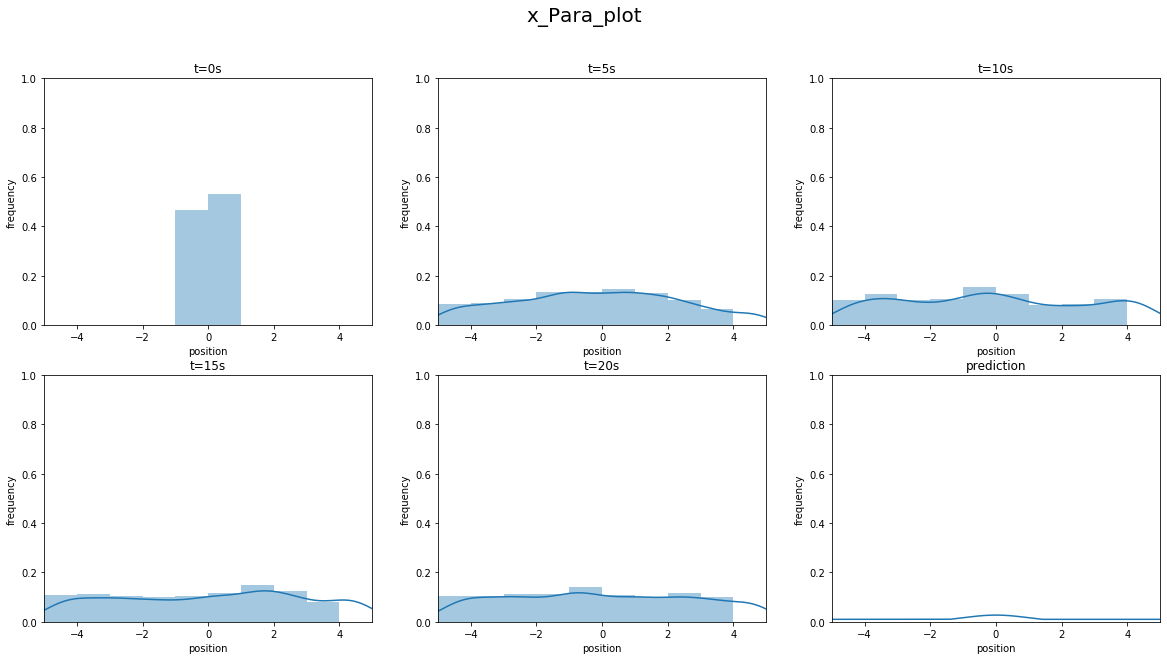

In [14]:
# https://stackoverflow.com/questions/61881175/normed-histogram-y-axis-larger-than-1

dist_temp_t0  = np.hstack((x_Para_plot[:,int(length*0.00) + i] for i in range(hist_range)))
dist_temp_t5  = np.hstack((x_Para_plot[:,int(length*0.25) + i] for i in range(hist_range)))
dist_temp_t10 = np.hstack((x_Para_plot[:,int(length*0.50) + i] for i in range(hist_range)))
dist_temp_t15 = np.hstack((x_Para_plot[:,int(length*0.75) + i] for i in range(hist_range)))
dist_temp_t20 = np.hstack((x_Para_plot[:,int(length*1.00 - hist_range) + i] for i in range(hist_range)))

plt.rcParams["figure.figsize"] = (20,10)

fig, axs = plt.subplots(2,3)

for (m,n), subplot in np.ndenumerate(axs):
    subplot.set_xlim(-L, L)
    subplot.set_ylim(0, 1)
    axs[m,n].set(xlabel='position', ylabel='frequency')

sns.distplot(dist_temp_t0 , bins = np.arange(-5, 5, 1), norm_hist = True, kde = False ,ax = axs[0, 0])
axs[0, 0].set_title('t=0s')
sns.distplot(dist_temp_t5 , bins = np.arange(-5, 5, 1), norm_hist = True, kde = True , ax = axs[0, 1])
axs[0, 1].set_title('t=5s')
sns.distplot(dist_temp_t10, bins = np.arange(-5, 5, 1), norm_hist = True, kde = True , ax = axs[0, 2])
axs[0, 2].set_title('t=10s')
sns.distplot(dist_temp_t15, bins = np.arange(-5, 5, 1), norm_hist = True, kde = True , ax = axs[1, 0])
axs[1, 0].set_title('t=15s')
sns.distplot(dist_temp_t20, bins = np.arange(-5, 5, 1), norm_hist = True, kde = True , ax = axs[1, 1])
axs[1, 1].set_title('t=20s')
#subplot.set_ylim(0, 100) #for prediction plot only
axs[1, 2].plot(x_predict, p1_predict * 0.01) #p1_predict is oringinal, p2_predict is normalized???
axs[1, 2].set_title('prediction')

plt.suptitle('x_Para_plot', size  = 20)

C:\Users\hwSRI\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.
C:\Users\hwSRI\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  
C:\Users\hwSRI\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\hwSRI\anac

Text(0.5, 0.98, 'x_Para')

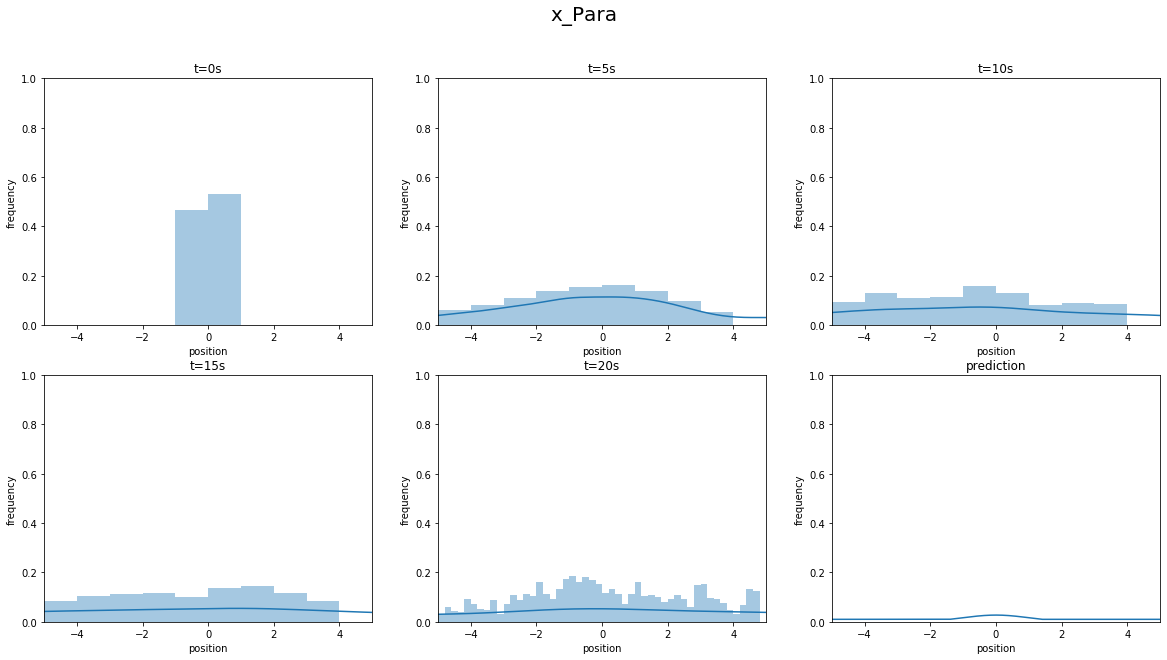

In [15]:
dist_temp_t0  = np.hstack((x_Para[:,int(length*0.00) + i] for i in range(hist_range)))
dist_temp_t5  = np.hstack((x_Para[:,int(length*0.25) + i] for i in range(hist_range)))
dist_temp_t10 = np.hstack((x_Para[:,int(length*0.50) + i] for i in range(hist_range)))
dist_temp_t15 = np.hstack((x_Para[:,int(length*0.75) + i] for i in range(hist_range)))
dist_temp_t20 = np.hstack((x_Para[:,int(length*1.00 - hist_range) + i] for i in range(hist_range)))

plt.rcParams["figure.figsize"] = (20,10)

fig, axs = plt.subplots(2,3)

for (m,n), subplot in np.ndenumerate(axs):
    subplot.set_xlim(-L, L)
    subplot.set_ylim(0, 1)
    axs[m,n].set(xlabel='position', ylabel='frequency')

sns.distplot(dist_temp_t0 , bins = np.arange(-5, 5, 1), norm_hist = True, kde = False ,ax = axs[0, 0])
axs[0, 0].set_title('t=0s')
sns.distplot(dist_temp_t5 , bins = np.arange(-5, 5, 1), norm_hist = True, kde = True , ax = axs[0, 1])
axs[0, 1].set_title('t=5s')
sns.distplot(dist_temp_t10, bins = np.arange(-5, 5, 1), norm_hist = True, kde = True , ax = axs[0, 2])
axs[0, 2].set_title('t=10s')
sns.distplot(dist_temp_t15, bins = np.arange(-5, 5, 1), norm_hist = True, kde = True , ax = axs[1, 0])
axs[1, 0].set_title('t=15s')
sns.distplot(dist_temp_t20, bins = np.arange(-5, 5, 0.2), norm_hist = True, kde = True , ax = axs[1, 1])
axs[1, 1].set_title('t=20s')
#subplot.set_ylim(0, 100) #for prediction plot only
axs[1, 2].plot(x_predict, p1_predict * 0.01) #p1_predict is oringinal, p2_predict is normalized???
axs[1, 2].set_title('prediction')

plt.suptitle('x_Para', size  = 20)

In [50]:
# 2D hist plot
# https://stackoverflow.com/questions/24523670/how-do-i-use-colorbar-with-hist2d-in-matplotlib-pyplot
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.hist2d.html
# https://matplotlib.org/3.1.1/gallery/axes_grid1/scatter_hist_locatable_axes.html#sphx-glr-gallery-axes-grid1-scatter-hist-locatable-axes-py
#for i in np.arange(30):
#    plt.hist2d(x_Para[i, 500], y_Para[i, 500])

density2d, x_edges, y_edges = np.histogram2d(np.reshape(x_Para_plot[:, 500:4000], -1), np.reshape(y_Para_plot[:, 500:4000], -1), bins=50, density=True)

In [51]:
print(y_edges[25])
print(np.shape(x_Para_plot))

-2.3065105381192552e-10
(10000, 8000)


(51,)

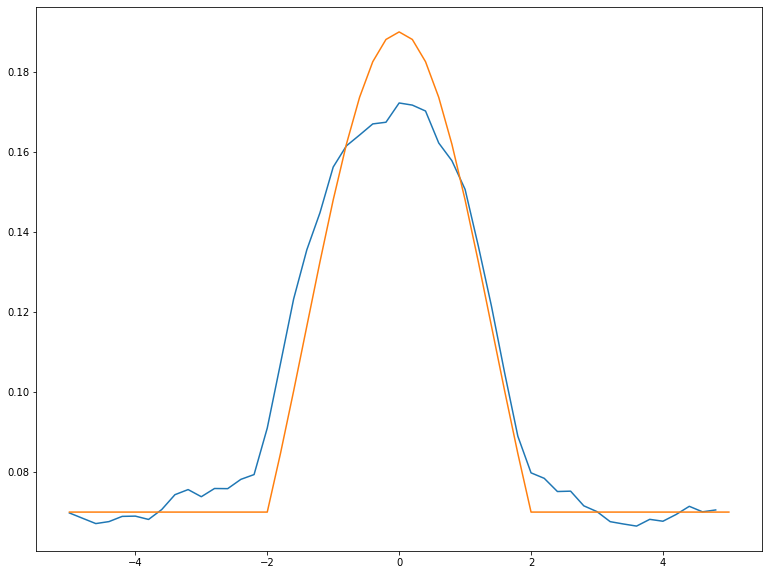

In [52]:
pdf_predict = np.exp(-Potential_Para(x_edges)) / DiffCoef_Para(x_edges)
pdf_predict = pdf_predict / np.sum(pdf_predict) / (2*L/50)
pdf_simulation = density2d[:, 25] / np.sum(density2d[:, 25]) / (2*L/50)
plt.plot(x_edges[:-1], pdf_simulation)
plt.plot(x_edges, pdf_predict)
np.shape(pdf_predict)

In [40]:
'''
plt.rcParams["figure.figsize"] = (13,10)
h = plt.hist2d(x_Para[:, 600], y_Para[:, 600])
plt.colorbar(h[3])
plt.xlim(-15,15)
plt.ylim(-15,15)
'''

'\nplt.rcParams["figure.figsize"] = (13,10)\nh = plt.hist2d(x_Para[:, 600], y_Para[:, 600])\nplt.colorbar(h[3])\nplt.xlim(-15,15)\nplt.ylim(-15,15)\n'

# MSD

In [ ]:
msd_all = np.zeros((test_number,length))
msd_mean = np.zeros(length)
for i in np.arange(test_number):
    msd = msd_fft(np.vstack((x_Para[i], y_Para[i])).T)
    msd_all[i] = msd
    plt.plot(np.arange(len(msd)),msd)
# plt.xlim(0, 500)
#plt.ylim(0, 20)
# plt.legend(np.arange(test_number), loc = 1, bbox_to_anchor = (1.05, 1))
plt.title("x_Para")

In [ ]:
for n in range(length):
    msd_mean[n] = np.mean(msd_all[:,n])

In [ ]:
plt.plot(np.arange(len(msd_mean)),msd_mean)
plt.xlim(0, 100)
plt.ylim(0, 5)
plt.plot((0,100),(0,2))

In [ ]:
# https://stackoverflow.com/questions/9538525/calculating-slopes-in-numpy-or-scipy
# https://math.stackexchange.com/questions/2565098/vector-notation-for-the-slope-of-a-line-using-simple-regression/2642719#2642719

msd_mean_lr_x = np.arange(len(msd_mean)) - np.mean(np.arange(len(msd_mean)))
msd_mean_lr_y = msd_mean - np.mean(msd_mean)
slope = (msd_mean_lr_x.dot(msd_mean_lr_y)) / (msd_mean_lr_x.dot(msd_mean_lr_x))  #wrong some time?

In [ ]:
slope

In [ ]:
msd_all = np.zeros((test_number,length))
msd_mean = np.zeros(length)
for i in np.arange(test_number):
    msd = msd_fft(np.vstack((x_Para_plot[i], y_Para_plot[i])).T)
    msd_all[i] = msd
    plt.plot(np.arange(len(msd)),msd)
# plt.xlim(0, 500)
#plt.ylim(0, 20)
# plt.legend(np.arange(test_number), loc = 1, bbox_to_anchor = (1.05, 1))
plt.title("x_Para_plot")

In [ ]:
for n in range(length):
    msd_mean[n] = np.mean(msd_all[:,n])

In [ ]:
plt.plot(np.arange(len(msd_mean)),msd_mean)
plt.xlim(0, 500)
plt.ylim(0, 20)

In [ ]:
msd_mean_lr_x = np.arange(len(msd_mean[0:300])) - np.mean(np.arange(len(msd_mean[0:300])))
msd_mean_lr_y = msd_mean[0:300] - np.mean(msd_mean[0:300])
slope = (msd_mean_lr_x.dot(msd_mean_lr_y)) / (msd_mean_lr_x.dot(msd_mean_lr_x))

In [ ]:
slope